##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# This Colab requires TF 2.5.
#!pip install -U tensorflow>=2.5

In [2]:
#!pip install tensorflow_hub

In [15]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [46]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
}

IMAGES_FOR_TEST = {
    "Yoda": "D:\\Nogizaka46photo\\Yoda\\test1.jpg",
    "Test":"D:\\IA\\train_data\\train_3.jpg"
}


In [47]:
# Clone the tensorflow models repository
#!git clone --depth 1 https://github.com/tensorflow/models

In [48]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [49]:
PATH_TO_LABELS = 'D:\\IA\\OCR\\Tensorflow\\models\\research\\object_detection\\data\\mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use.
Select the architecture and it will be loaded automatically.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

**Tip:** if you want to read more details about the selected model, you can follow the link (model handle) and read additional documentation on TF Hub. After you select a model, we will print the handle to make it easier.

In [50]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet50 V1 800x1333'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 800x1333
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1


## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.


In [51]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


## Loading an image

Let's try the model on a simple image. To help with this, we provide a list of test images.

Here are some simple things to try out if you are curious:
* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works.  Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

**Be careful:** when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.



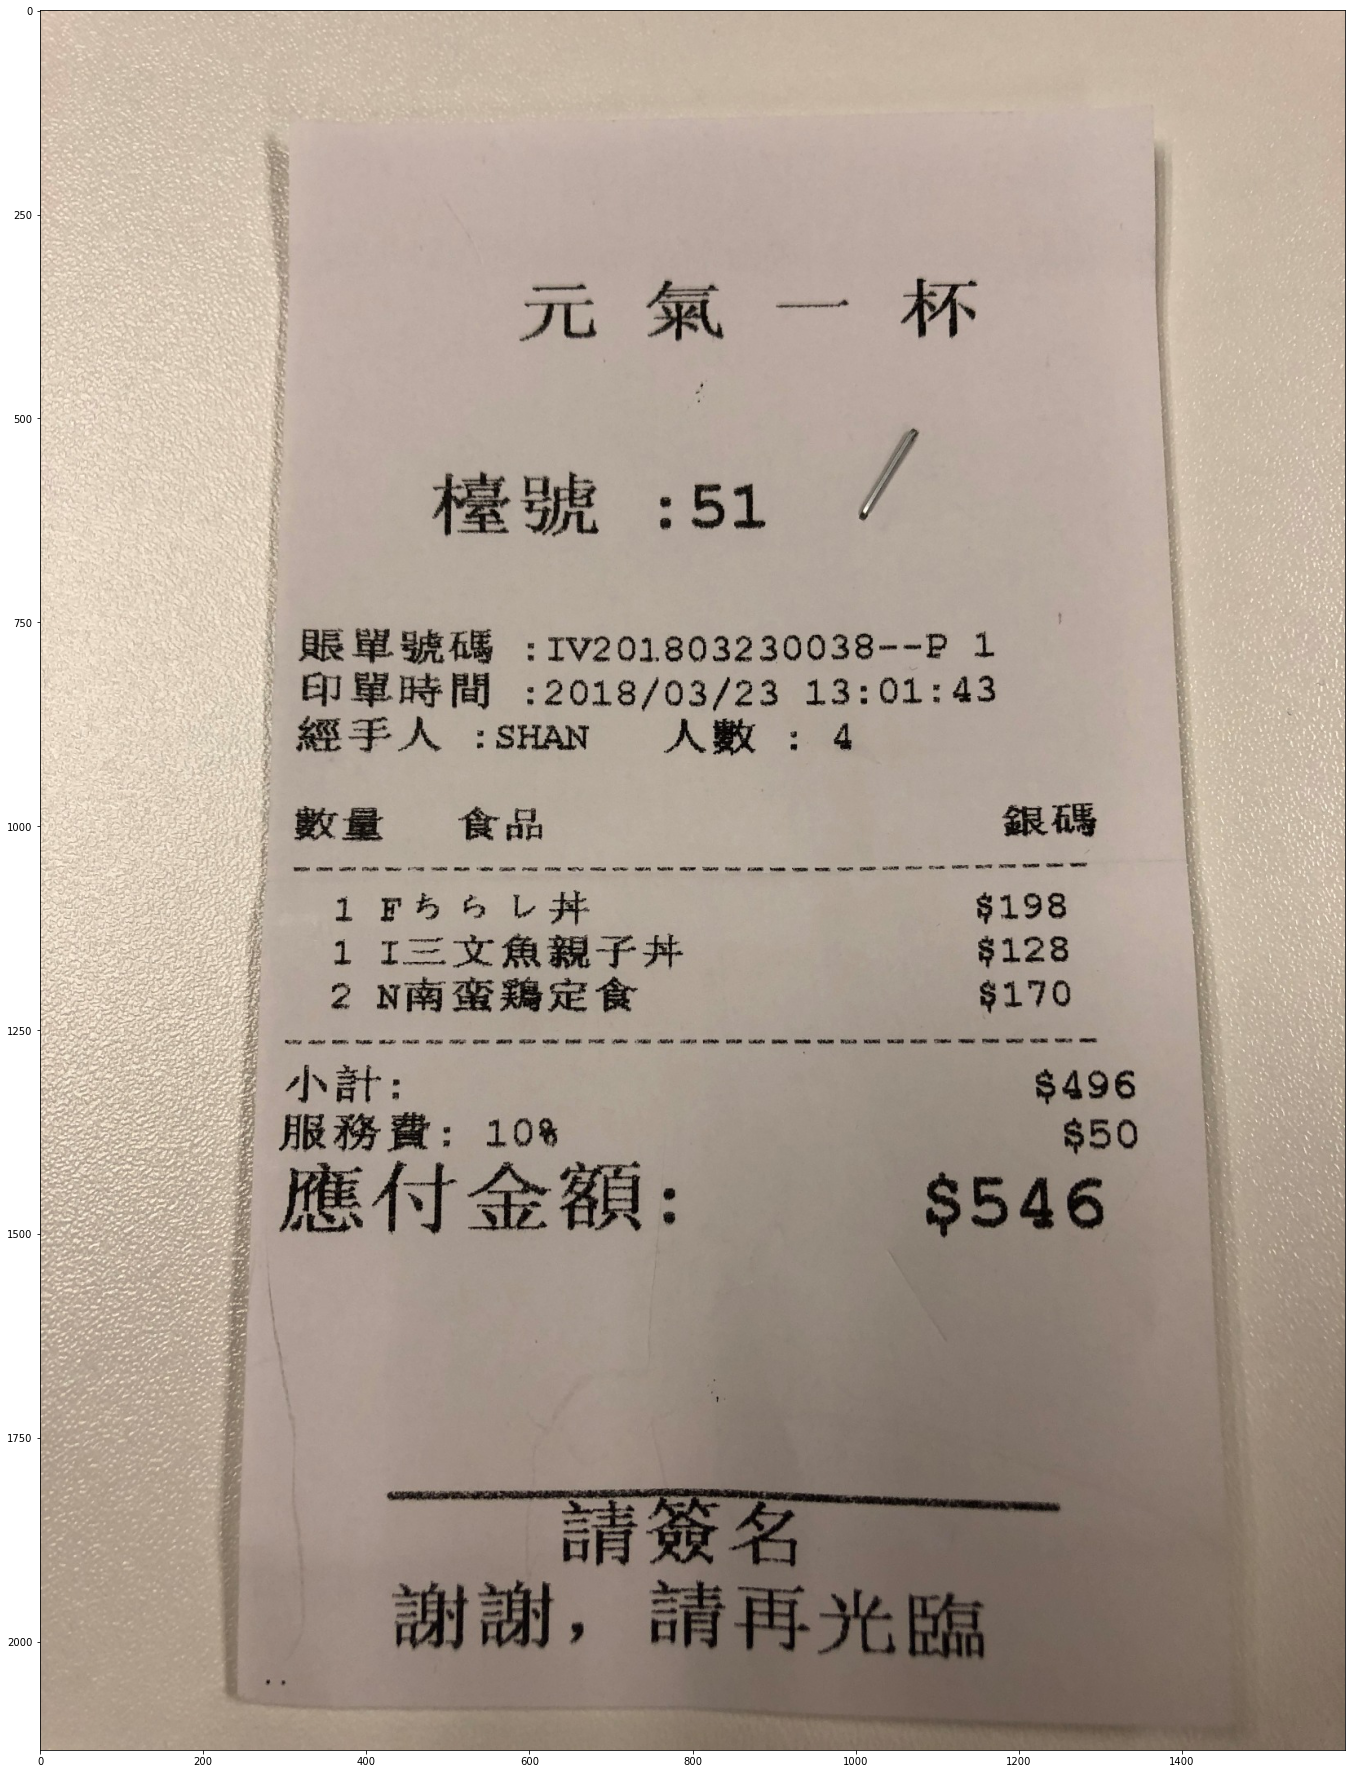

In [52]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Test' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [53]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_anchor_indices', 'detection_boxes', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores'])


## [Optional]

Among the available object detection models there's Mask R-CNN and the output of this model allows instance segmentation.

To visualize it we will use the same method we did before but adding an aditional parameter: `instance_masks=output_dict.get('detection_masks_reframed', None)`


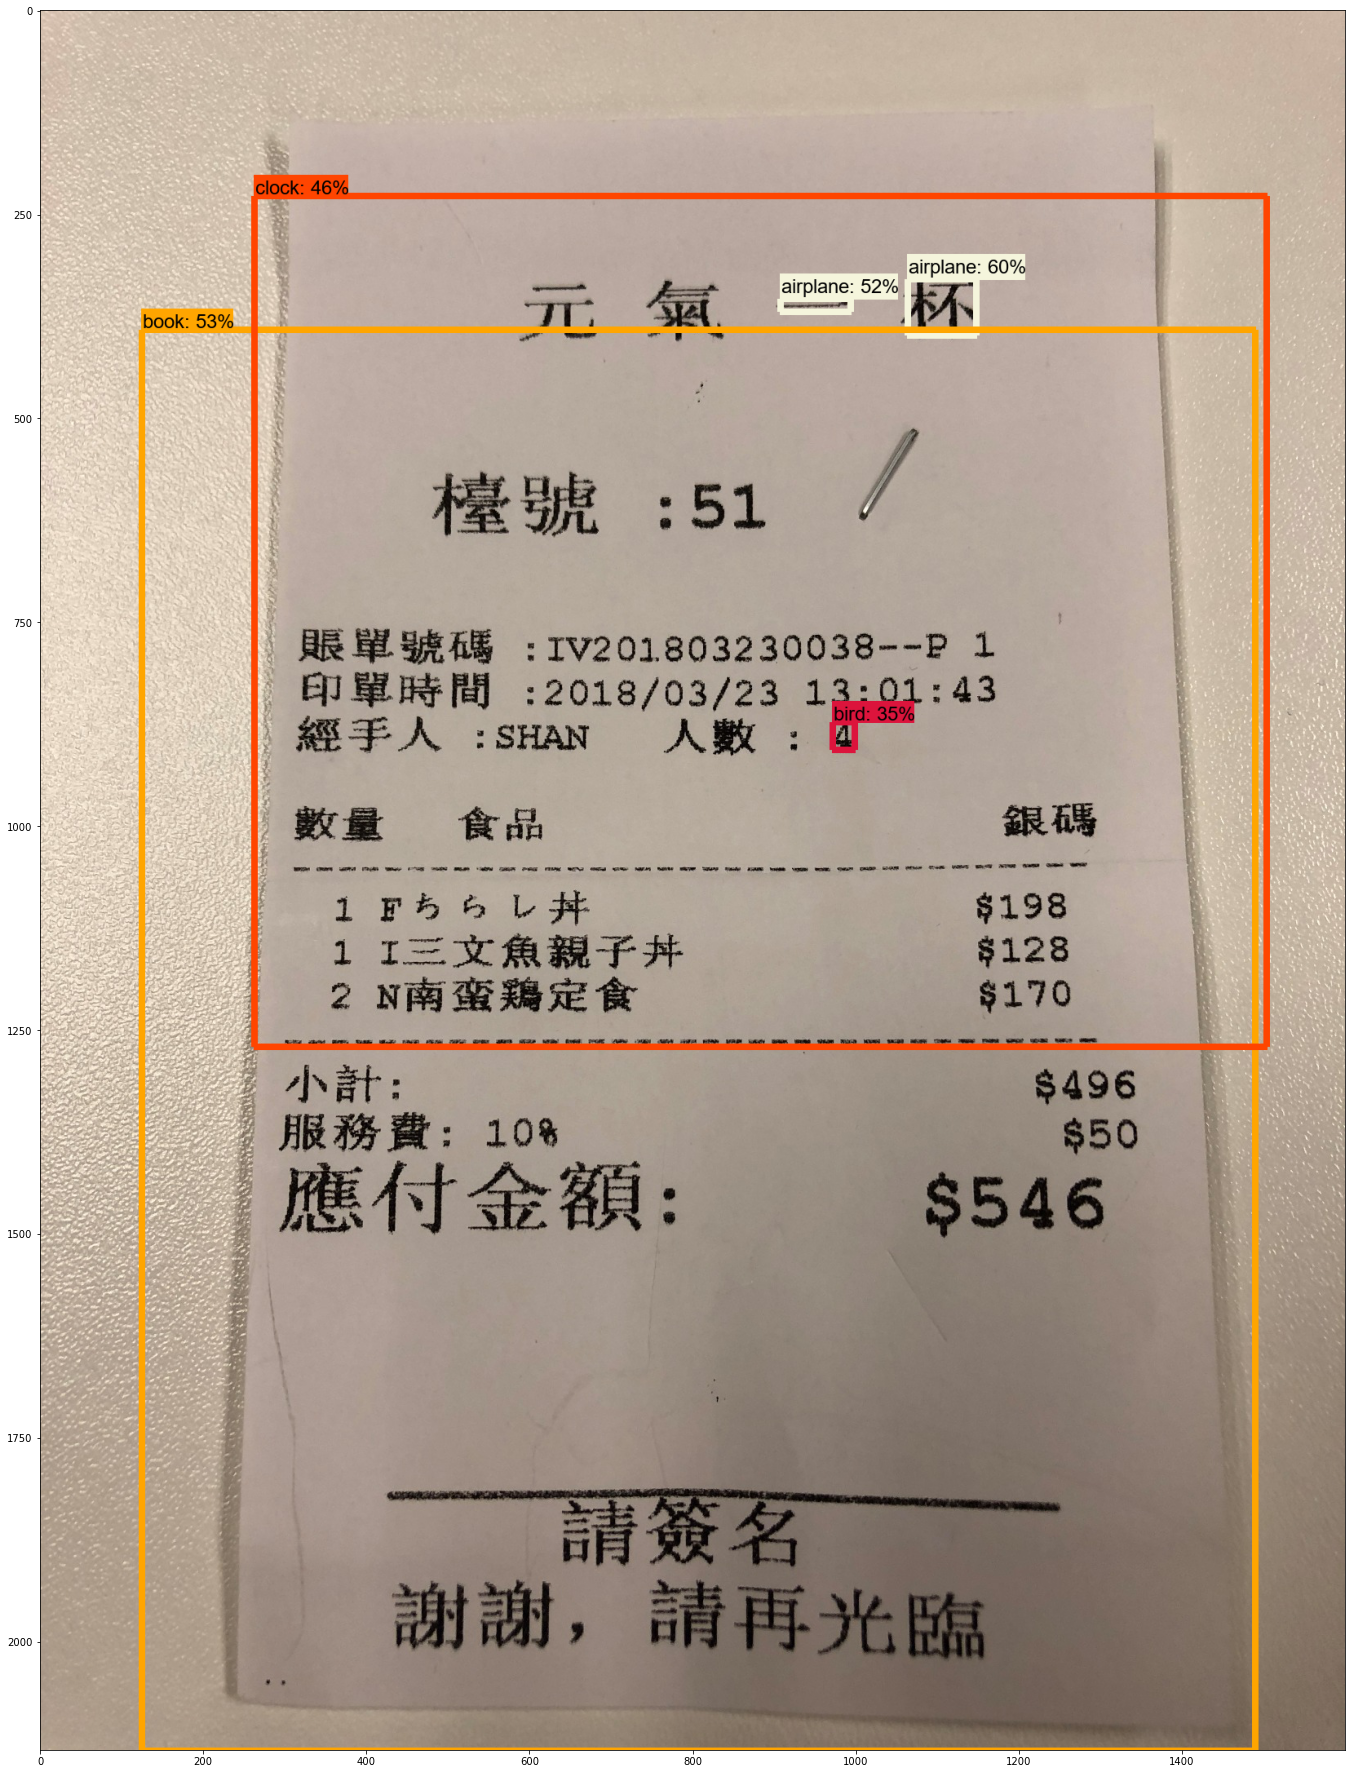

In [54]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()